In [1]:
import pandas as pd
from config import *

df = pd.read_csv(all)

C:\Users\benja\AppData\Local\Temp\ipykernel_23624\2130263240.py:4: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(all)


In [2]:
from filtering import formatDF, discretizarDatos
data = formatDF(df)
data.loc[data["vendedor"].isna(), "vendedor"] = data.loc[data["vendedor"].isna(), "tipoVendedor"]
data = discretizarDatos(data)

# drop columns: activo, URL, file, tipoVendedor, ciudad
data = data.drop(['activo', 'URL', 'file', 'tipoVendedor','ciudad'], axis=1)
data = data.loc[data["tipoPropiedad"] != 3]
data['barrio'] = data['barrio'].astype('category').cat.codes

C:\Users\benja\AppData\Local\Temp\ipykernel_23624\3200405269.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data = formatDF(df)


In [5]:
# convertir fecha a datetime y luego a int
data['fechaUltimaActualizacion'] = pd.to_datetime(data['fechaUltimaActualizacion'])
data['fechaUltimaActualizacion'] = data['fechaUltimaActualizacion'].astype('int64')

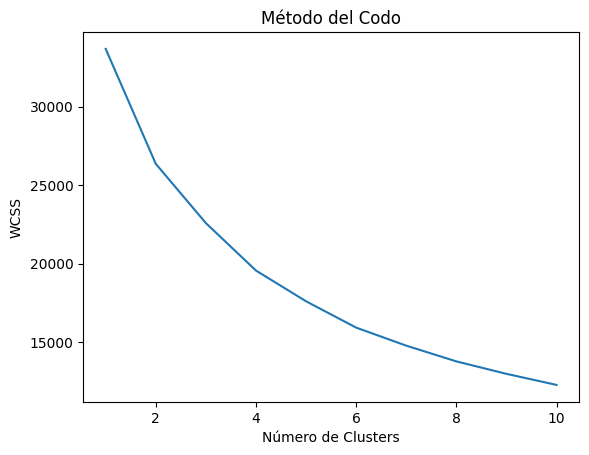

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio', 'fechaUltimaActualizacion']
data_for_clustering = data[features]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Escalar los datos para que todas las características tengan la misma escala

# Determinar el número óptimo de clusters utilizando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=100, random_state=33)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo para encontrar el número óptimo de clusters
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()


In [10]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=200, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Agregar la información de los clusters al DataFrame original
data['clusterKM'] = clusters

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

features_knn = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio', 'fechaUltimaActualizacion']

data_for_knn_train = data[features_knn]
target_column = 'precioUSD'
target = data[target_column]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_for_knn_train, target, train_size=0.99, random_state=33)

# Eliminar train_test_split y usar todo el conjunto de entrenamiento
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)

# Crear instancias de modelos con diferentes configuraciones
models = dict()
r2_scores = []
for i in range(1, 20):
    models[f'knn{i}'] = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m.fit(X_train_scaled, y_train)
    scores_r2 = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_scores.append((f'knn{i}', scores_r2.mean()))

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

print("Entrenando modelos...")

print("Random Forest...")
random_forest_model = RandomForestRegressor(n_estimators=800, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

print("Gradient Boosting...")
gradient_boosting_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)

print("Modelos entrenados.")

random_forest_r2 = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='r2')
gradient_boosting_r2 = cross_val_score(gradient_boosting_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("\nRandom Forest:")
print(f"R^2: {random_forest_r2.mean()}")
print("\nGradient Boosting:")
print(f"R^2: {gradient_boosting_r2.mean()}")

Entrenando modelos...
Random Forest...
Gradient Boosting...
Modelos entrenados.

Random Forest:
R^2: 0.7612263765996156

Gradient Boosting:
R^2: 0.7721795863616222


In [14]:
sorted_models = [model[0] for model in sorted(r2_scores, key=lambda x: x[1], reverse=True)][:8]
models_w_weight = []
weights = [4,3,3,2,2,1,1]
for i in range(len(weights)):
    models_w_weight.append(((sorted_models[i], models[sorted_models[i]]), weights[i]))
    
models_w_weight.append((('RF', RandomForestRegressor(n_estimators=800, random_state=42)), 4))
models_w_weight.append((('XGBoost', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)), 4))

In [15]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

ensemble_model = VotingRegressor(estimators=[model[0] for model in models_w_weight], 
                                 weights=[w[1] for w in models_w_weight])
ensemble_model.fit(X_train_scaled, y_train)

# Escalar todos los datos
X_testing = X_test.copy()
X_test_scaled = scaler_knn.transform(X_test)
all_data_predictions = ensemble_model.predict(X_test_scaled)
X_testing.loc[:, 'precioUSDPredicted'] = all_data_predictions
X_testing.loc[:, "precioUSD"] = y_test

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

# Imprimir resultados
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")
print(f"RMSE del modelo ensamblado: {ensemble_rmse}")

R^2 en el conjunto de prueba para el modelo ensamblado: 0.855609688896992
RMSE del modelo ensamblado: 31103.01715186467


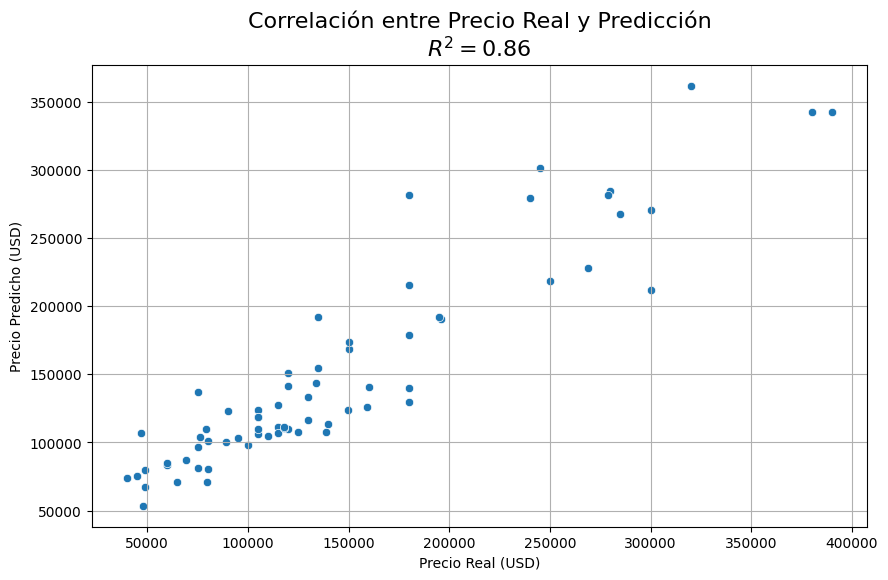

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions)
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2={ensemble_r2:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()

In [19]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Calcular los residuos del modelo ensamblado
residuals = y_test - all_data_predictions
smoothed_residuals = lowess(residuals, range(len(residuals)), is_sorted=True, frac=0.1, it=0)
corrected_predictions_smoothed = all_data_predictions + smoothed_residuals[:, 1]

# Crear un modelo AdaBoost para reducir los residuales
residual_boosting_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=50, random_state=42)

residual_boosting_model.fit(X_test_scaled, residuals)
residual_predictions_boosting = residual_boosting_model.predict(X_test_scaled)
corrected_predictions_boosting = all_data_predictions + residual_predictions_boosting

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [22]:
corrected_r2_boosting = r2_score(y_test, corrected_predictions_boosting)
corrected_rmse_boosting = np.sqrt(mean_squared_error(y_test, corrected_predictions_boosting))

print(f"R^2 para el modelo ensamblado corregido con residuos de boosting: {corrected_r2_boosting}")
print(f"RMSE del modelo ensamblado corregido con residuos de boosting: {corrected_rmse_boosting}")

R^2 para el modelo ensamblado corregido con residuos de boosting: 0.9940041676138496
RMSE del modelo ensamblado corregido con residuos de boosting: 6338.087574238487


R^2 en el conjunto de prueba para el modelo corrector derivado: 0.9995726916880716
RMSE del modelo corrector derivado: 1692.0148260063952


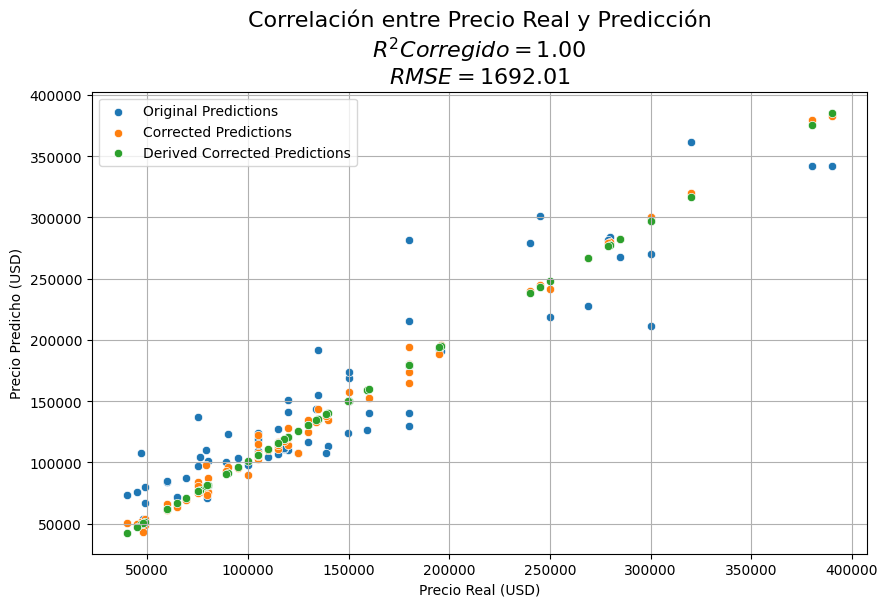

In [25]:
# Ponderación de los modelos de corrección
weight_smoothed_model = 0
weight_boosting_model = 1

# Combinar las predicciones corregidas de cada modelo con los pesos
ensemble_corrected_predictions = (
    weight_smoothed_model * corrected_predictions_smoothed +
    weight_boosting_model * corrected_predictions_boosting
)

# Calcular el R^2 y RMSE para el modelo ensamblado
ensemble_r2 = r2_score(y_test, ensemble_corrected_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_corrected_predictions))

# Calcular la línea de mejor ajuste
fit_line = np.polyfit(y_test, ensemble_corrected_predictions, 1)
fit_line_equation = np.poly1d(fit_line)

# Calcular predicciones según la línea de mejor ajuste
fit_line_predictions = fit_line_equation(y_test)

fit_line_r2 = r2_score(y_test, fit_line_predictions)
fit_line_rmse = np.sqrt(mean_squared_error(y_test, fit_line_predictions))

print(f"R^2 en el conjunto de prueba para el modelo corrector derivado: {fit_line_r2}")
print(f"RMSE del modelo corrector derivado: {fit_line_rmse}")

# Crear un gráfico de dispersión para comparar las predicciones originales y corregidas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions, label='Original Predictions')
sns.scatterplot(x=y_test, y=ensemble_corrected_predictions, label='Corrected Predictions')
sns.scatterplot(x=y_test, y=fit_line_predictions, label='Derived Corrected Predictions')
# Titulo: con R^2 del modelo corrector derivado y RMSE redondeados a 2dp
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2 Corregido={fit_line_r2:.2f}$\n$RMSE={fit_line_rmse:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.legend()
plt.grid(True)
plt.show()